In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm

In [ ]:
!pip install causalml

     |████████████████████████████████| 406 kB 5.2 MB/s 
     |████████████████████████████████| 564 kB 37.6 MB/s 
     |████████████████████████████████| 1.8 MB 13.3 MB/s 
     |████████████████████████████████| 718 kB 19.1 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050920 sha256=5a1c942bdaac29658194857e326490bdb68f8396932985ad9d16c445357a3fd4
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [ ]:
!pip install pylift

     |████████████████████████████████| 100 kB 4.3 MB/s 
  Created wheel for pylift: filename=pylift-0.1.5-py3-none-any.whl size=26030 sha256=438914445bcd9516ba9c804f8ae3a9cc16f442059c076d9b74990eaf1f406e8b
  Stored in directory: /root/.cache/pip/wheels/c3/ec/9d/69405e922f27de16e66aada83dce7227f6fddc71639d7cfe66
Successfully built pylift


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 45 kB/s 


In [ ]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# import dask.dataframe as dd
import numpy as np
import scipy as sp

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from IPython.display import Image

seed=10

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.tlearner as tlearner
from scipy.stats import chi2_contingency
from typing import List, Tuple

Criteo

In [ ]:
dataset = fetch_criteo()

In [ ]:
for c in dataset.data.columns:
    dataset.data[c] = pd.to_numeric(dataset.data[c], downcast='float')

dataset.treatment = dataset.treatment.astype('int8')
dataset.target = dataset.target.astype('int8')

In [ ]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (9785714, 12)
Validation shape: (4193878, 12)


In [ ]:
# S Learner

In [ ]:
trmnt_val.shape, y_val.shape

((4193878,), (4193878,))

In [ ]:
# T Learner
model_t_learner = tlearner.BaseTRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

model_t_learner.fit(
    X=X_train.values,
    treatment=treat_train.values,
    y=y_train.values
)

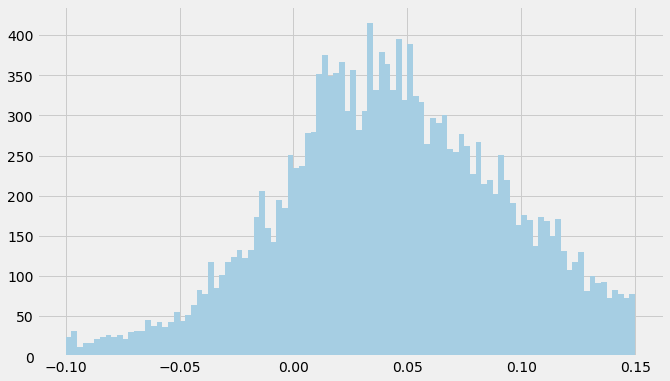

In [ ]:
t_learner_pred = pd.DataFrame(model_t_learner.predict(X_test))
t_learner_pred = t_learner_pred.rename(columns={0:'score'})

t_learner_pred = t_learner_pred.join(treat_test.reset_index(drop=True)) # ['treatment']
t_learner_pred = t_learner_pred.join(y_test.reset_index(drop=True)) # ['visit']

plt.figure(figsize=(10, 6))
plt.hist(t_learner_pred['score'], range=(-0.1, 0.15), bins=100)
plt.show()

In [ ]:
t_learner_pred.head()

,score,segment,visit
0,0.080916,0.0,0.0
1,0.055362,0.0,0.0
2,0.117203,0.0,0.0
3,0.146300,1.0,0.0
4,0.176332,0.0,0.0


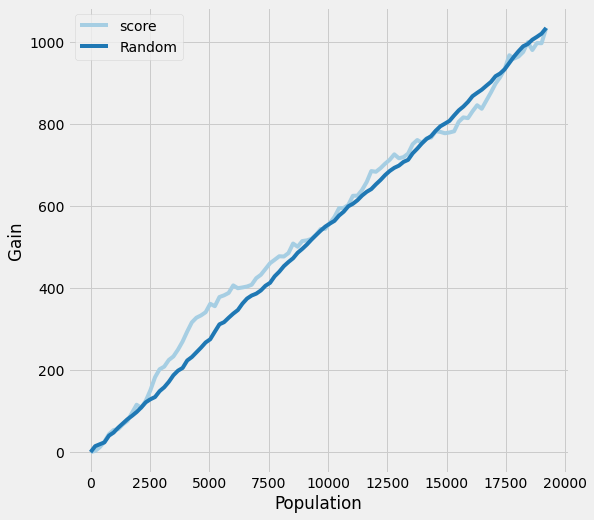

In [ ]:
cmetrics.plot_gain(
    t_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)

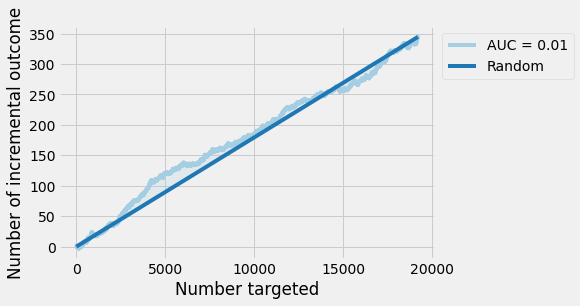

In [ ]:
from sklift.viz import plot_qini_curve
plot_qini_curve(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'], perfect=False);

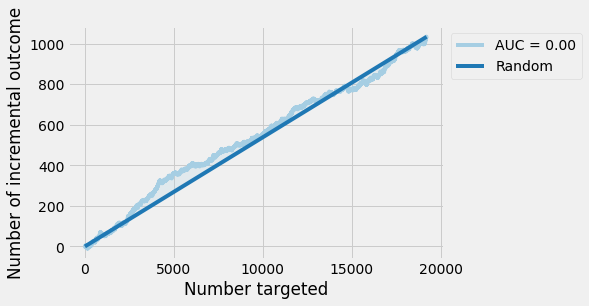

In [ ]:
from sklift.viz import plot_uplift_curve
plot_uplift_curve(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'], perfect=False);

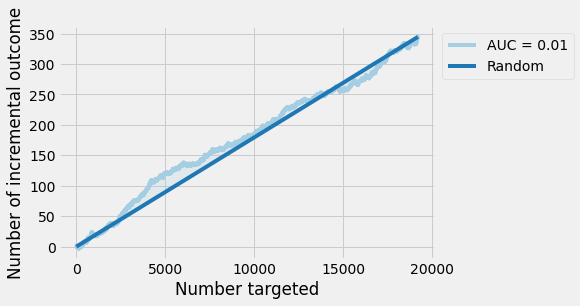

In [ ]:
from sklift.viz import plot_qini_curve
plot_qini_curve(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'], perfect=False);

In [ ]:
auuc_score = cmetrics.auuc_score(
    t_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)
print(auuc_score)

score     0.519363
Random    0.503375
dtype: float64


In [ ]:
qini_score = cmetrics.qini_score(
    t_learner_pred,
    treatment_col='segment',
    outcome_col='visit',
    normalize=False
)
print(qini_score)

score     5.468992
Random    0.000000
dtype: float64


In [ ]:
from sklift.metrics import qini_auc_score
print(qini_auc_score(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment']))

0.00739324067331909


In [ ]:
from sklift.metrics import uplift_auc_score
print(uplift_auc_score(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment']))

0.0034949083346559697


In [ ]:
from sklift.metrics import weighted_average_uplift
print(weighted_average_uplift(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment']))

0.05378680646183951


In [ ]:
from sklift.metrics import uplift_at_k
print(uplift_at_k(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'], strategy='overall', k=0.1))

0.059683669598543126


In [ ]:
df_all_scores = pd.DataFrame()
df_all_metrics= pd.DataFrame()

In [ ]:
df_all_metrics['model'] = 'default'
df_all_metrics['uplift@k'] = 'default'
df_all_metrics['uplift_weighted'] = 'default'
df_all_metrics['auuc'] = 'default'
df_all_metrics['qini'] = 'default'

In [ ]:
# add scores to total df
df_all_scores['t_learner_pred'] = t_learner_pred['score']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 'model' : 't_learner',
                       'uplift@k' : uplift_at_k(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'], strategy='overall', k=0.1),
                       'uplift_weighted' : weighted_average_uplift(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment']),
                       'auuc' : uplift_auc_score(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment']),
                       'qini' : qini_auc_score(t_learner_pred['visit'], t_learner_pred['score'], t_learner_pred['segment'])
    
}, ignore_index=True)

In [ ]:
df_all_scores.head()

,t_learner_pred
0,0.080916
1,0.055362
2,0.117203
3,0.146300
4,0.176332


In [ ]:
df_all_metrics.head()

,model,uplift@k,uplift_weighted,auuc,qini
0,t_learner,0.059684,0.053787,0.003495,0.007393


In [ ]:
# X Learner

In [ ]:
model_x_learner = xlearner.BaseXRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

model_x_learner.fit(
    X=X_train.values,
    treatment=treat_train.values,
    y=y_train.values
)

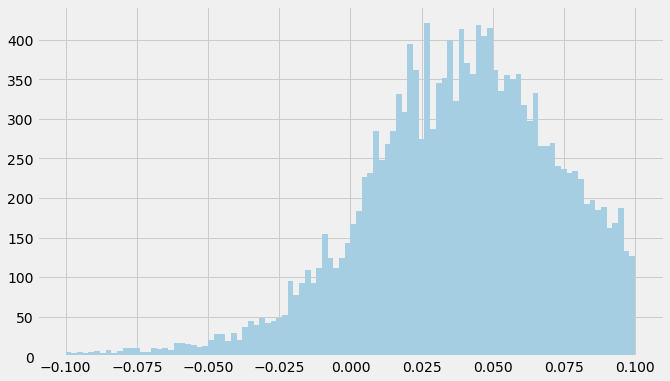

In [ ]:
x_learner_pred = pd.DataFrame(model_x_learner.predict(X_test))
x_learner_pred = x_learner_pred.rename(columns={0:'score'})

x_learner_pred = x_learner_pred.join(treat_test.reset_index(drop=True)) # ['treatment']
x_learner_pred = x_learner_pred.join(y_test.reset_index(drop=True)) # ['visit']

plt.figure(figsize=(10, 6))
plt.hist(x_learner_pred['score'], range=(-0.1, 0.1), bins=100)
plt.show()

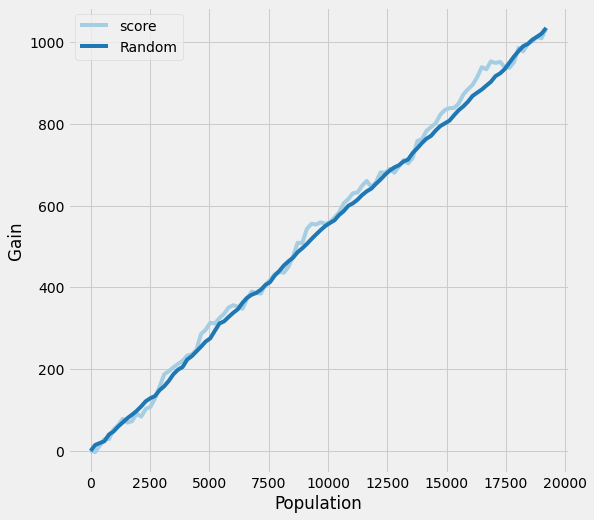

In [ ]:
cmetrics.plot_gain(
    x_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)

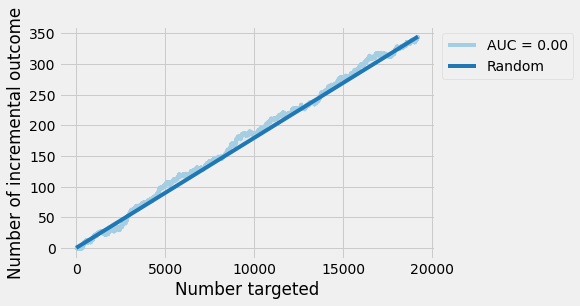

In [ ]:
from sklift.viz import plot_qini_curve
plot_qini_curve(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment'], perfect=False);

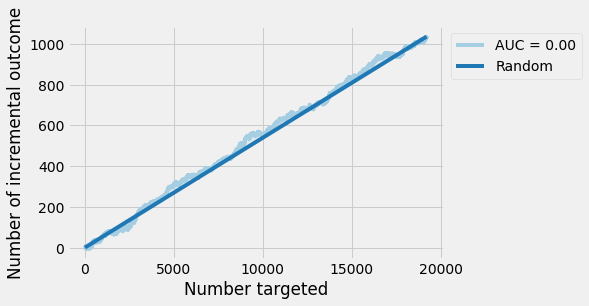

In [ ]:
from sklift.viz import plot_uplift_curve
plot_uplift_curve(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment'], perfect=False);

In [ ]:
# add scores to total df
df_all_scores['x_learner_pred'] = x_learner_pred['score']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 'model' : 'x_learner',
                       'uplift@k' : uplift_at_k(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment'], strategy='overall', k=0.1),
                       'uplift_weighted' : weighted_average_uplift(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment']),
                       'auuc' : uplift_auc_score(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment']),
                       'qini' : qini_auc_score(x_learner_pred['visit'], x_learner_pred['score'], x_learner_pred['segment'])
    
}, ignore_index=True)

In [ ]:
df_all_scores.shape

(19200, 2)

In [ ]:
df_all_metrics.head()

,model,uplift@k,uplift_weighted,auuc,qini
0,t_learner,0.059684,0.053787,0.003495,0.007393
1,x_learner,0.045429,0.053943,0.002245,0.004846


In [ ]:
# R Learner

In [ ]:
model_r_learner = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

model_r_learner.fit(
    X=X_train.values,
    treatment=treat_train.values,
    y=y_train.values
)

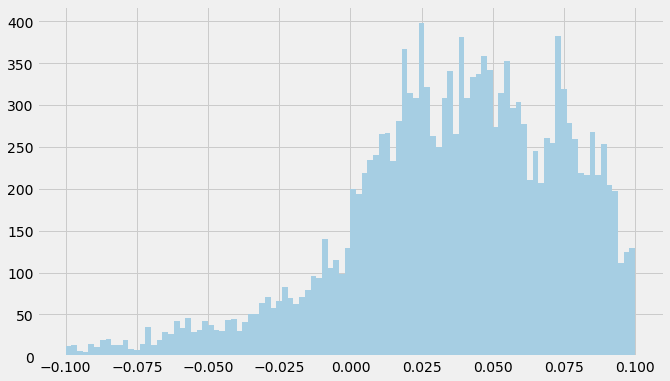

In [ ]:
r_learner_pred = pd.DataFrame(model_r_learner.predict(X_test))
r_learner_pred = r_learner_pred.rename(columns={0:'score'})

r_learner_pred = r_learner_pred.join(treat_test.reset_index(drop=True)) # ['treatment']
r_learner_pred = r_learner_pred.join(y_test.reset_index(drop=True)) # ['visit']

plt.figure(figsize=(10, 6))
plt.hist(r_learner_pred['score'], range=(-0.1, 0.1), bins=100)
plt.show()

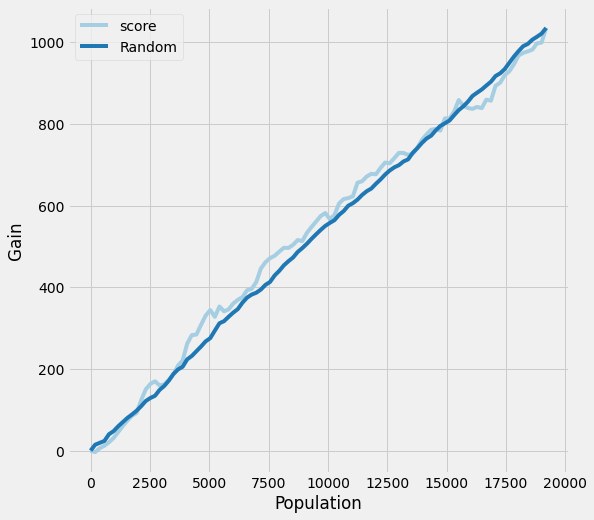

In [ ]:
cmetrics.plot_gain(
    r_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)

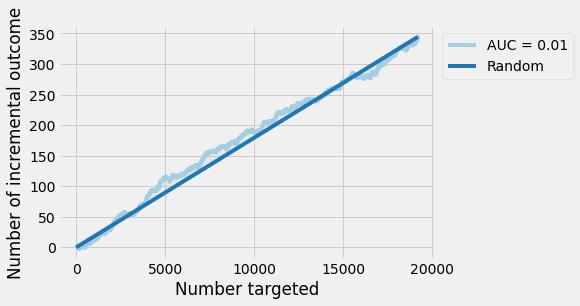

In [ ]:
from sklift.viz import plot_qini_curve
plot_qini_curve(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment'], perfect=False);

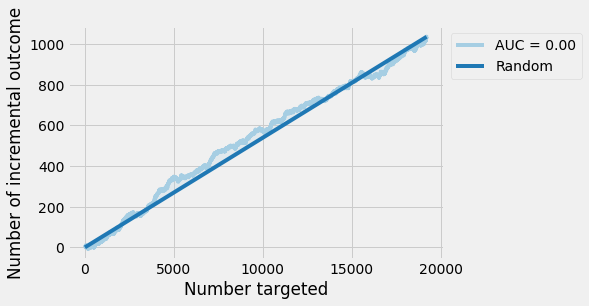

In [ ]:
from sklift.viz import plot_uplift_curve
plot_uplift_curve(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment'], perfect=False);

In [ ]:
auuc = uplift_auc_score(y_test, pred_uplift_ct, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

In [ ]:
auuc_score = cmetrics.auuc_score(
    r_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)
print(auuc_score)


score     0.515714
Random    0.503375
dtype: float64


In [ ]:
from sklift.metrics import uplift_auc_score
uplift_auc_score(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment'])

0.0028362784810293407

In [ ]:
# add scores to total df
df_all_scores['r_learner_pred'] = r_learner_pred['score']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 'model' : 'r_learner',
                       'uplift@k' : uplift_at_k(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment'], strategy='overall', k=0.1),
                       'uplift_weighted' : weighted_average_uplift(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment']),
                       'auuc' : uplift_auc_score(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment']),
                       'qini' : qini_auc_score(r_learner_pred['visit'], r_learner_pred['score'], r_learner_pred['segment'])
    
}, ignore_index=True)

In [ ]:
df_all_scores.shape

(19200, 3)

In [ ]:
df_all_metrics.head()

,model,uplift@k,uplift_weighted,auuc,qini
0,t_learner,0.059684,0.053787,0.003495,0.007393
1,x_learner,0.045429,0.053943,0.002245,0.004846
2,r_learner,0.047693,0.053991,0.002836,0.005411


In [ ]:
# Uplift trees
import causalml.inference.tree as ctree

In [ ]:
model_tree = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='KL',
    n_estimators=20,
    max_depth=3,
    min_samples_leaf=500
)
model_tree.fit(
    X=X_train.values,
    treatment=treat_train.apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=y_train.values
)

In [ ]:
cols_features = X_train.columns

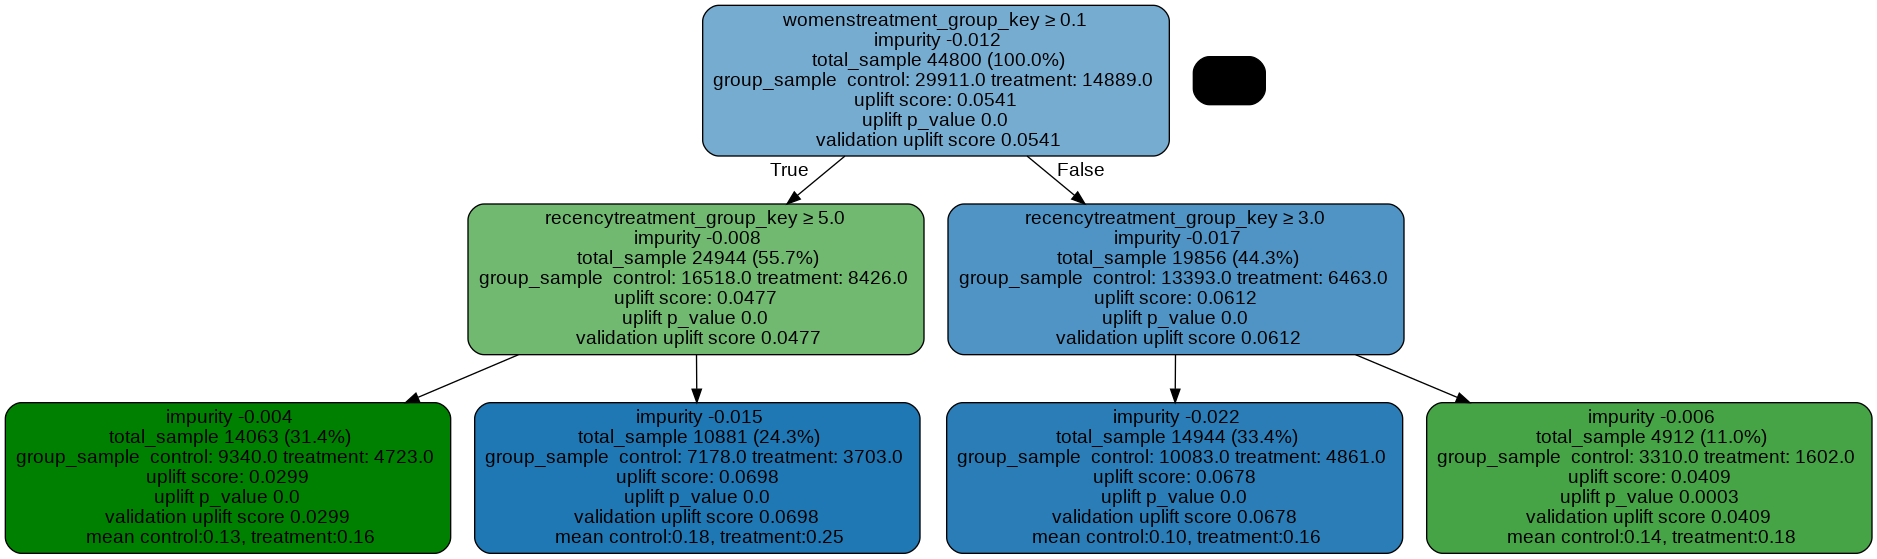

In [ ]:
graph = ctree.uplift_tree_plot(model_tree.uplift_forest[0].fitted_uplift_tree, cols_features)
Image(graph.create_png())

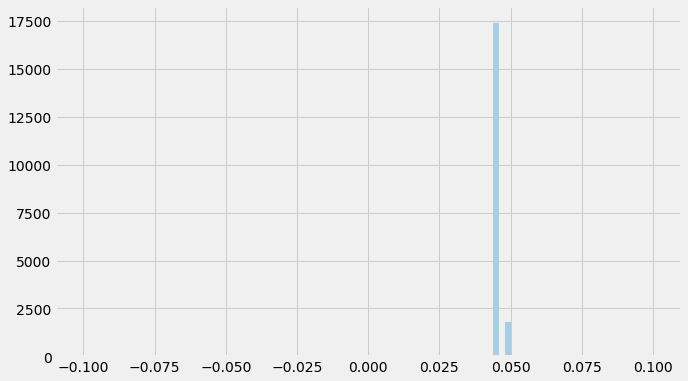

In [ ]:
tree_pred = pd.DataFrame(model_tree.predict(X_test))
tree_pred = tree_pred.rename(columns={0:'score'})

tree_pred = tree_pred.join(treat_test.reset_index(drop=True)) # ['treatment']
tree_pred = tree_pred.join(y_test.reset_index(drop=True)) # ['visit']

plt.figure(figsize=(10, 6))
plt.hist(tree_pred['score'], range=(-0.1, 0.1), bins=100)
plt.show()

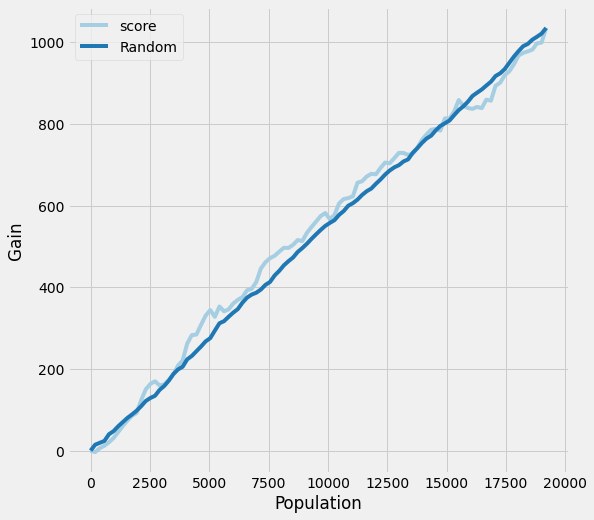

In [ ]:
cmetrics.plot_gain(
    r_learner_pred,
    treatment_col='segment',
    outcome_col='visit'
)

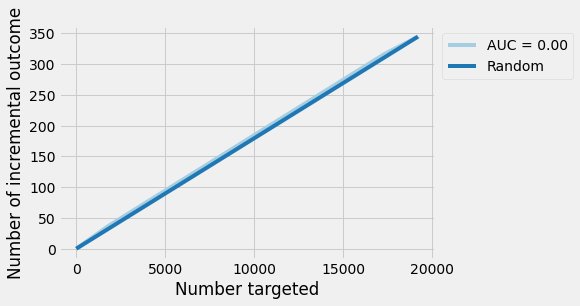

In [ ]:
from sklift.viz import plot_qini_curve
plot_qini_curve(tree_pred['visit'], tree_pred['score'], tree_pred['segment'], perfect=False);

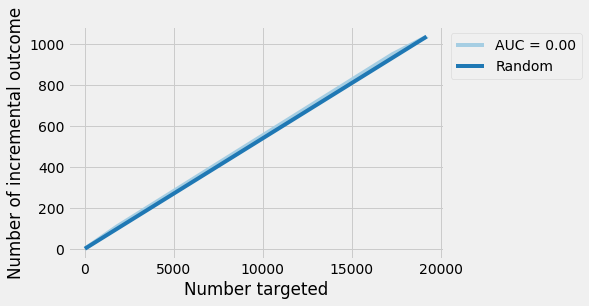

In [ ]:
from sklift.viz import plot_uplift_curve
plot_uplift_curve(tree_pred['visit'], tree_pred['score'], tree_pred['segment'], perfect=False);

In [ ]:
# add scores to total df
df_all_scores['tree_pred'] = tree_pred['score']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 'model' : 'tree',
                       'uplift@k' : uplift_at_k(tree_pred['visit'], tree_pred['score'], tree_pred['segment'], strategy='overall', k=0.1),
                       'uplift_weighted' : weighted_average_uplift(tree_pred['visit'], tree_pred['score'], tree_pred['segment']),
                       'auuc' : uplift_auc_score(tree_pred['visit'], tree_pred['score'], tree_pred['segment']),
                       'qini' : qini_auc_score(tree_pred['visit'], tree_pred['score'], tree_pred['segment'])
    
}, ignore_index=True)

In [ ]:
df_all_scores.shape

(19200, 4)

In [ ]:
df_all_metrics.head()

,model,uplift@k,uplift_weighted,auuc,qini
0,t_learner,0.059684,0.053787,0.003495,0.007393
1,x_learner,0.045429,0.053943,0.002245,0.004846
2,r_learner,0.047693,0.053991,0.002836,0.005411
3,tree,0.063814,0.053959,0.002287,0.004921


In [ ]:
# Metrics table

In [ ]:
df_all_scores = df_all_scores.drop('visit', axis=1)

In [ ]:
df_all_scores = df_all_scores.join(treat_test.reset_index(drop=True))
df_all_scores = df_all_scores.join(y_test.reset_index(drop=True))
print(df_all_scores.shape)

(19200, 6)


In [ ]:
df_all_scores.head()

,t_learner_pred,x_learner_pred,r_learner_pred,tree_pred,segment,visit
0,0.080916,0.071154,-0.054638,0.045946,0.0,0.0
1,0.055362,0.049519,0.067657,0.045946,0.0,0.0
2,0.117203,0.046722,0.076943,0.045946,0.0,0.0
3,0.146300,0.110422,0.090044,0.045946,1.0,0.0
4,0.176332,0.092944,0.093985,0.045946,0.0,0.0


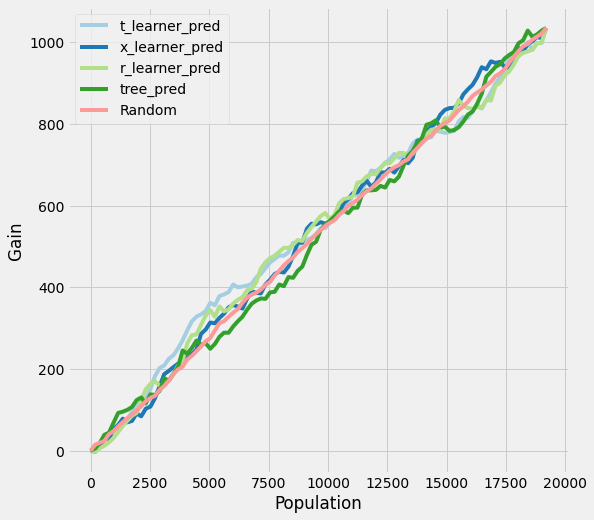

In [ ]:
# Common graphs
cmetrics.plot_gain(
    df_all_scores,
    treatment_col='segment',
    outcome_col='visit',
)

Hillstrom data

In [ ]:
from sklift.datasets import fetch_hillstrom
dataset = fetch_hillstrom()

  0%|          | 0.00/443k [00:00<?, ?iB/s]

In [ ]:
data, target, treatment = dataset.data, dataset.target, dataset.treatment

In [ ]:
data.shape, target.shape, treatment.shape

((64000, 8), (64000,), (64000,))

In [ ]:
target.name, treatment.name

('visit', 'segment')

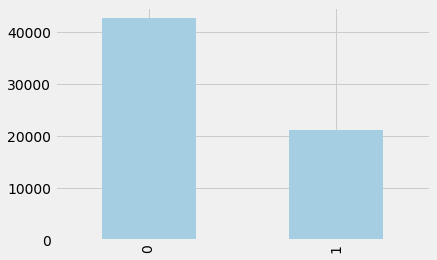

In [ ]:
treat = {   "Womens E-Mail": 0,
            "No E-Mail": 0, 
            "Mens E-Mail": 1}
treatment = treatment.map(treat)
dfT = pd.concat([treatment, target], axis=1)

treatment.value_counts().plot(kind="bar", grid="True");

In [ ]:
features = data.columns.tolist()
dfX = data[features]
dfX.tail(4)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel
63999,1,4) $350 - $500,472.82,0,1,Surburban,0,Web


In [ ]:
dfXn = pd.get_dummies(dfX, dtype=float)
dfXn.tail(4)

,recency,history,mens,womens,newbie,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
63996,5,38.91,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
63997,6,29.99,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
63998,1,552.94,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
63999,1,472.82,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
dfXn.shape

(64000, 18)

In [ ]:
for c in dfXn.columns:
    dfXn[c] = pd.to_numeric(dfXn[c], downcast='float')

treatment = treatment.astype('float')
target = target.astype('float')

In [ ]:
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(   dfXn,
                            treatment,
                            target,
                            stratify=dfT,
                            test_size=0.3,
                            random_state=42)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (44800, 18)
testing: (19200, 18)


In [ ]:
X_train.dtypes

recency                             float32
history                             float32
mens                                float32
womens                              float32
newbie                              float32
history_segment_1) $0 - $100        float32
history_segment_2) $100 - $200      float32
history_segment_3) $200 - $350      float32
history_segment_4) $350 - $500      float32
history_segment_5) $500 - $750      float32
history_segment_6) $750 - $1,000    float32
history_segment_7) $1,000 +         float32
zip_code_Rural                      float32
zip_code_Surburban                  float32
zip_code_Urban                      float32
channel_Multichannel                float32
channel_Phone                       float32
channel_Web                         float32
dtype: object

In [ ]:
X_train.head()

,recency,history,mens,womens,newbie,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
5467,4.0,77.660004,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
24952,11.0,128.149994,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
44614,1.0,250.750000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3556,7.0,46.130001,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7849,11.0,29.990000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
y_train.dtypes

dtype('float64')

In [ ]:
treat_train.dtypes

dtype('float64')

In [ ]:
y_train

5467     0
24952    0
44614    0
3556     0
7849     0
        ..
41474    0
28298    0
23796    0
3761     0
11088    0
Name: visit, Length: 44800, dtype: int8